## Importing Libraries

In [1]:
!pip install efficientnet --quiet
!pip install fsspec --quiet
!pip install gcsfs --quiet
!pip install -U pip install -U tensorboard_plugin_profile==2.3.0 --quiet

In [2]:
import os
import re
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn.utils import compute_class_weight

## Config

In [3]:
def get_strategy():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy, tpu

In [4]:
tpu_strategy, tpu = get_strategy()

Running on TPU  ['10.29.142.186:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.29.142.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.29.142.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
class Config:
  gcs_path = 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf'
  tf_records = gcs_path + '/tfrecords'
  data = gcs_path + '/train.csv'

  AUTO = tf.data.experimental.AUTOTUNE

  img_size = 256
  batch_size = 128

In [6]:
config = Config()

## Creating the dataset

In [7]:
filenames = tf.io.gfile.glob(config.tf_records + '/train*.tfrec')
filenames[:3]

['gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train00-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train01-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train02-2071.tfrec']

In [8]:
#======================================================================================
#======================================================================================

def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 
  image_tensor = tf.image.resize(normalized, [config.img_size, config.img_size])
  return image_tensor, example['target']

#======================================================================================
#======================================================================================

def load_dataset(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=config.AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=config.AUTO)

#======================================================================================
#======================================================================================

def get_training_dataset(filenames):
  dataset = load_dataset(filenames)
  def data_augment(image, target):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, target
  augmented = dataset.map(data_augment, num_parallel_calls=config.AUTO)
  return augmented.repeat().shuffle(2048).batch(config.batch_size).prefetch(config.AUTO) 

#======================================================================================
#======================================================================================

training_dataset = get_training_dataset(filenames[:-4])
validation_dataset = load_dataset(filenames[-4:]).batch(config.batch_size).prefetch(config.AUTO)

In [9]:
for i in training_dataset:
  print(i[0].shape)
  break

(128, 256, 256, 3)


In [10]:
for i in validation_dataset:
  print(i[0].shape)
  break

(128, 256, 256, 3)


## Computing Output Bias

In [11]:
df = pd.read_csv(config.data)
df.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


In [12]:
df.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [13]:
output_bias = np.log(584/32542)
output_bias

-4.0203858588710375

## Creating the model

In [14]:
def create_model(output_bias):
  pretrained_model = efn.EfficientNetB7(include_top=False, input_shape=(config.img_size, config.img_size, 3))
  pretrained_model.trainable = True
  output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
  ])
  model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = tf.keras.metrics.AUC()
  )
  return model

with tpu_strategy.scope():
  model = create_model(output_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 8, 8, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
_________________________________________________________________


## Training the model

In [15]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(filenames[:-4])
n_valid = count_data_items(filenames[-4:])
train_steps = count_data_items(filenames[:-4]) // config.batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  24852 , STEPS PER EPOCH:  194
VALIDATION IMAGES:  8274


Learning rate per epoch:


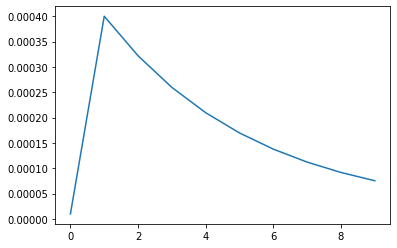

In [16]:
EPOCHS = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 1
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [17]:
es = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, min_delta=0.001, patience=2)

history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback, es])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
194/194 [==============================] - 321s 561ms/step - loss: 0.0875 - auc: 0.6224 - val_loss: 0.0842 - val_auc: 0.7076
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004.
194/194 [==============================] - 85s 438ms/step - loss: 0.0831 - auc: 0.7490 - val_loss: 0.0716 - val_auc: 0.8531
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000322.
194/194 [==============================] - 84s 436ms/step - loss: 0.0747 - auc: 0.8300 - val_loss: 0.0730 - val_auc: 0.8666
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
194/194 [==============================] - 86s 443ms/step - loss: 0.0690 - auc: 0.8707 - val_loss: 0.0739 - val_auc: 0.8605


In [18]:
final_accuracy = history.history["val_auc"][-5:]
print("FINAL AUC MEAN-5: ", np.mean(final_accuracy))

FINAL AUC MEAN-5:  0.8219572007656097


In [20]:
model.save_weights('./trained.h5')